# Герасименко Андрей
# ПМ21-3
# Курсовая работа по дисциплине " Машинное обучение в семантическом и сетевом анализе"
# Тема: Построение эмбеддингов узлов графового набора данных 
# из специализированной предметной области с помощью графовых нейронных сетей
# Научный руководитель: Бахматов Андрей Вячеславович

# Датасет LiveJournal social network
# Мы используем очищенную версию из которой я удалил следующие строчки, потому что они не нужны, и пришлось бы код адаптировать, чтобы он игнорировал комментарии

```
# Directed graph (each unordered pair of nodes is saved once): soc-LiveJournal1.txt 
# Directed LiveJournal friednship social network
# Nodes: 4847571 Edges: 68993773
# FromNodeId	ToNodeId
```


In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split


In [3]:
def load_data(filepath):
    edges = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            from_node, to_node = map(int, line.strip().split('\t'))
            edges.append((from_node, to_node))
    return edges

# Путь к файлу данных
file_path = 'soc-LiveJournal1.txt'
edges = load_data(file_path)


# тут я проверяю, что все данные корректно загрузились

In [4]:
edges[:30]

[(0, 2),
 (0, 1),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (0, 21),
 (0, 22),
 (0, 23),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 28),
 (0, 29),
 (0, 30)]

In [5]:
# Разделение данных на обучающий и тестовый наборы
edges_train, edges_test = train_test_split(edges, test_size=0.2, random_state=42)

# Преобразование списка рёбер в тензоры PyTorch
edge_index_train = torch.tensor(edges_train, dtype=torch.long).t().contiguous()
edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()

# Находим максимальный индекс узла среди всех узлов, участвующих в рёбрах
max_node_index = max(edge_index_train.max().item(), edge_index_test.max().item()) + 1

# Создание объектов Data
data_train = Data(edge_index=edge_index_train, num_nodes=max_node_index)
data_test = Data(edge_index=edge_index_test, num_nodes=max_node_index)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    edge_index=data_train.edge_index,  # Индексы рёбер для обучения
    embedding_dim=32,                 # Размерность вектора эмбеддинга
    walk_length=20,                   # Длина случайного блуждания
    context_size=10,                  # Размер окна контекста
    walks_per_node=10,                # Количество блужданий на узел
    num_negative_samples=1,           # Количество отрицательных примеров
    p=1,                              # Параметр возврата p
    q=1,                              # Параметр исхода q
    sparse=True                       # Использование разреженного обучения
).to(device)


# Загрузчики для обучения и тестирования
train_loader = model.loader(batch_size=48, shuffle=True, num_workers=os.cpu_count())
test_loader = model.loader(batch_size=48, shuffle=False, num_workers=os.cpu_count())

optimizer = optim.SparseAdam(list(model.parameters()), lr=0.01)

In [7]:
# Функция для обучения и оценки модели
def train_and_evaluate(model, train_loader, test_loader, device, epochs=10):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in train_loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for pos_rw, neg_rw in test_loader:
                loss = model.loss(pos_rw.to(device), neg_rw.to(device))
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

        print(f'Epoch: {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    return train_losses, test_losses

Epoch: 1, Train Loss: 1.0350, Test Loss: 0.8504
Epoch: 2, Train Loss: 0.9184, Test Loss: 0.7859
Epoch: 3, Train Loss: 0.7970, Test Loss: 0.7791
Epoch: 4, Train Loss: 0.7953, Test Loss: 0.7788
Epoch: 5, Train Loss: 0.7942, Test Loss: 0.7784
Epoch: 6, Train Loss: 0.7940, Test Loss: 0.7783
Epoch: 7, Train Loss: 0.7939, Test Loss: 0.7783
Epoch: 8, Train Loss: 0.7940, Test Loss: 0.7783
Epoch: 9, Train Loss: 0.7941, Test Loss: 0.7784
Epoch: 10, Train Loss: 0.7942, Test Loss: 0.7784
Epoch: 11, Train Loss: 0.7943, Test Loss: 0.7785
Epoch: 12, Train Loss: 0.7943, Test Loss: 0.7785
Epoch: 13, Train Loss: 0.7944, Test Loss: 0.7785
Epoch: 14, Train Loss: 0.7944, Test Loss: 0.7785
Epoch: 15, Train Loss: 0.7944, Test Loss: 0.7785


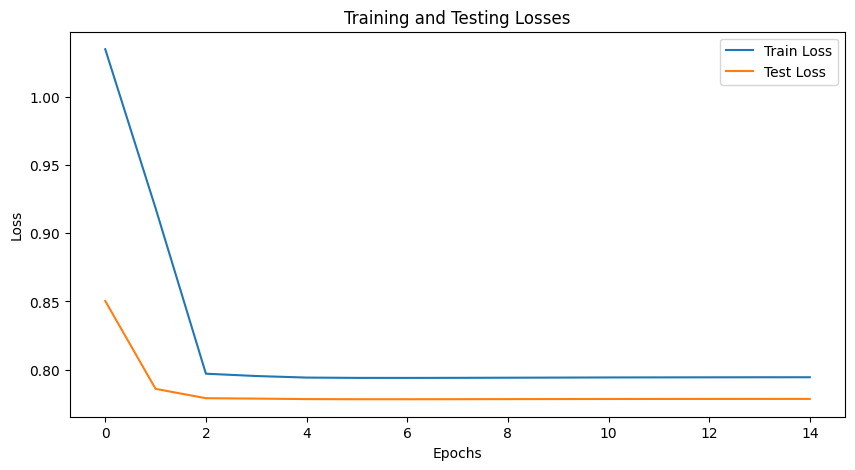

In [8]:
# Обучение модели и визуализация результатов
train_losses, test_losses = train_and_evaluate(model, train_loader, test_loader, device, epochs=15)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
def visualize_embeddings(model, data, device):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device)).detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    z_reduced = tsne.fit_transform(z)
    plt.figure(figsize=(10, 8))
    plt.scatter(z_reduced[:, 0], z_reduced[:, 1], s=2, alpha=0.5)
    plt.title('Node Embeddings Visualized with t-SNE')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


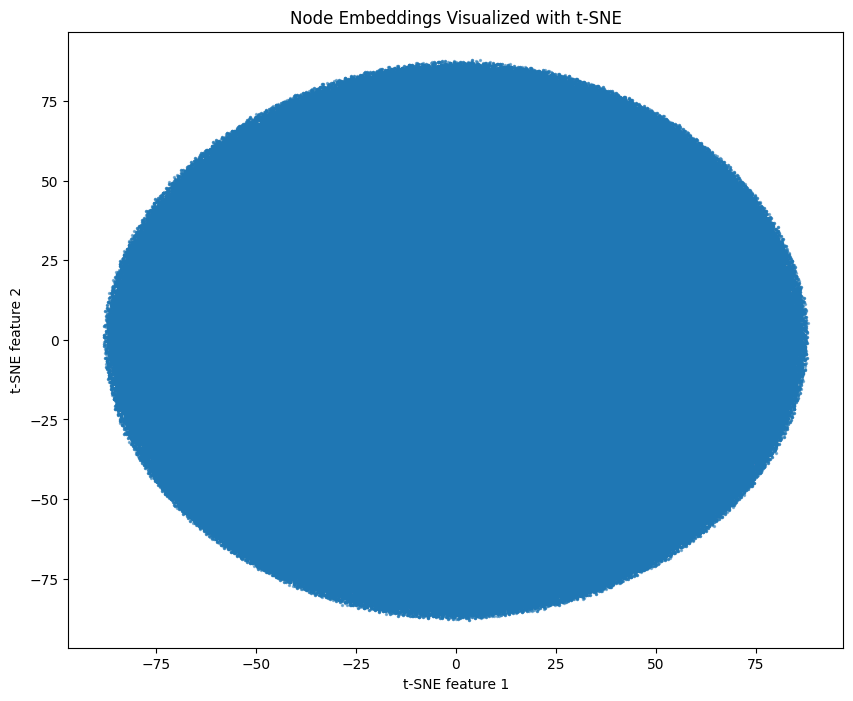

In [9]:
# Визуализация эмбеддингов
visualize_embeddings(model, data_train, device)

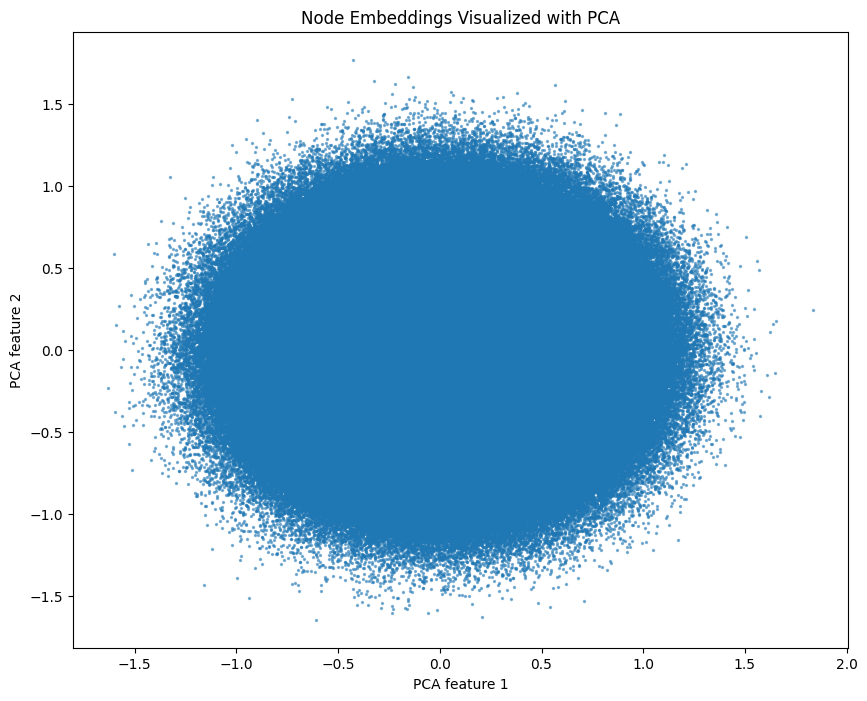

In [9]:
from sklearn.decomposition import PCA

def visualize_embeddings_with_pca(model, data, device):
    model.eval()
    with torch.no_grad():
        embeddings = model(torch.arange(data.num_nodes, device=device)).detach().cpu().numpy()

    # Применение PCA
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)

    # Визуализация
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], s=2, alpha=0.5)
    plt.title('Node Embeddings Visualized with PCA')
    plt.xlabel('PCA feature 1')
    plt.ylabel('PCA feature 2')
    plt.show()

# Вызов функции визуализации с PCA
visualize_embeddings_with_pca(model, data_train, device)


In [17]:
torch.save(model.state_dict(), 'node2vec_model_state.pth')


In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split


In [2]:
def load_data(filepath):
    edges = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            from_node, to_node = map(int, line.strip().split('\t'))
            edges.append((from_node, to_node))
    return edges

# Путь к файлу данных
file_path = 'soc-LiveJournal3.txt'
edges = load_data(file_path)


In [3]:
# Разделение данных на обучающий и тестовый наборы
edges_train, edges_test = train_test_split(edges, test_size=0.2, random_state=42)

# Преобразование списка рёбер в тензоры PyTorch
edge_index_train = torch.tensor(edges_train, dtype=torch.long).t().contiguous()
edge_index_test = torch.tensor(edges_test, dtype=torch.long).t().contiguous()

# Находим максимальный индекс узла среди всех узлов, участвующих в рёбрах
max_node_index = max(edge_index_train.max().item(), edge_index_test.max().item()) + 1

# Создание объектов Data
data_train = Data(edge_index=edge_index_train, num_nodes=max_node_index)
data_test = Data(edge_index=edge_index_test, num_nodes=max_node_index)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    edge_index=data_train.edge_index,
    embedding_dim=32,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True
).to(device)

# Загрузчики для обучения и тестирования
train_loader = model.loader(batch_size=48, shuffle=True, num_workers=0)
test_loader = model.loader(batch_size=48, shuffle=False, num_workers=0)

optimizer = optim.SparseAdam(list(model.parameters()), lr=0.01)

In [5]:
model.load_state_dict(torch.load('node2vec_model_state.pth'))

<All keys matched successfully>

In [6]:
model.eval()
with torch.no_grad():
    embeddings = model(torch.arange(data_train.num_nodes, device=device)).detach().cpu().numpy()

In [9]:
import torch
import pandas as pd
import igraph as ig

edges_df = pd.DataFrame(edges, columns=['source', 'target'])

nodes_df = pd.DataFrame({
    'id': range(len(embeddings)),
    'x': embeddings[:, 0],
    'y': embeddings[:, 1]
})

# Создание объекта графа
g = ig.Graph(directed=False)

# Добавление вершин
g.add_vertices(nodes_df['id'].tolist())

# Добавление рёбер
g.add_edges(edges_df.apply(tuple, axis=1).tolist())

# Установка координат узлов как атрибутов вершин
g.vs['x'] = nodes_df['x']
g.vs['y'] = nodes_df['y']

# Визуализация графа с использованием координат узлов
visual_style = {
    "vertex_size": 10,
    "vertex_color": "blue",
    "vertex_label": None,  # Можно установить None, если метки не нужны
    "edge_color": "gray",
    "bbox": (600, 600),
    "margin": 50
}

# Создание layout на основе координат 'x' и 'y'
layout = [(x, y) for x, y in zip(g.vs['x'], g.vs['y'])]
visual_style["layout"] = layout

# Рисуем граф
ig.plot(g, **visual_style)


In [10]:
import matplotlib.pyplot as plt

ig.plot(g, "output_graph.png", **visual_style)
plt.show()  # Показываем изображение, если это необходимо

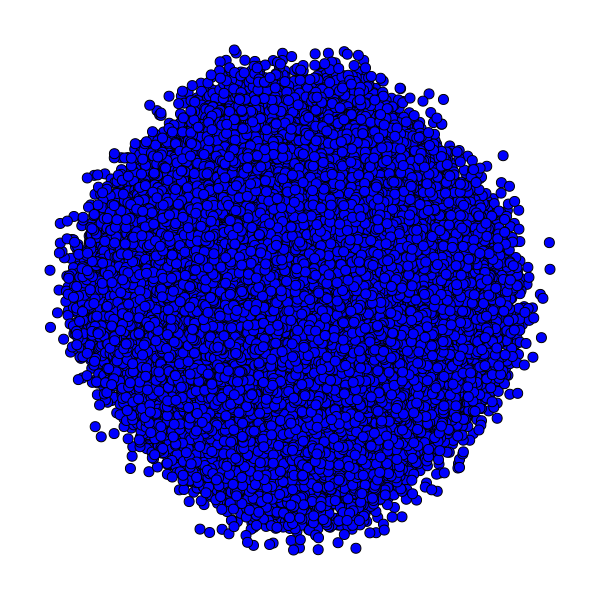

In [11]:
from IPython.display import Image, display

# Генерация и отображение изображения внутри ноутбука
plot_path = "output_graph.png"
ig.plot(g, plot_path, **visual_style)
display(Image(filename=plot_path))


In [21]:
import torch
import pandas as pd
import graphistry

#graphistry.register(api=3, protocol="https", server="hub.graphistry.com", personal_key_id="0XTGWMCKCR", personal_key_secret="YO08SFR1688Q3ZAR")
graphistry.register(api=3, username='KursachAndrey', password='3572202gF') 
model.eval()
with torch.no_grad():
    embeddings = model(torch.arange(data_train.num_nodes, device=device)).detach().cpu().numpy()

edges_df = pd.DataFrame(edges, columns=['source', 'target'])
nodes_df = pd.DataFrame({
    'id': range(len(embeddings)),
    'x': embeddings[:, 0],
    'y': embeddings[:, 1]
})

#nodes_sample = nodes_df.sample(n=800, random_state=42)  # случайная выборка 800 узлов

# Создание списка ID узлов в выборке
#sampled_node_ids = set(nodes_sample['id'])

# Фильтрация рёбер, чтобы оставить только те, что соединяют узлы из выборки
#edges_sample = edges_df[edges_df['source'].isin(sampled_node_ids) & edges_df['target'].isin(sampled_node_ids)]

# Обновление DataFrame для узлов и рёбер
#nodes_df = nodes_sample
#edges_df = edges_sample

plotter = graphistry.edges(edges_df).bind(source='source', destination='target')
plotter = plotter.nodes(nodes_df).bind(node='id', point_x='x', point_y='y')
plotter.plot()


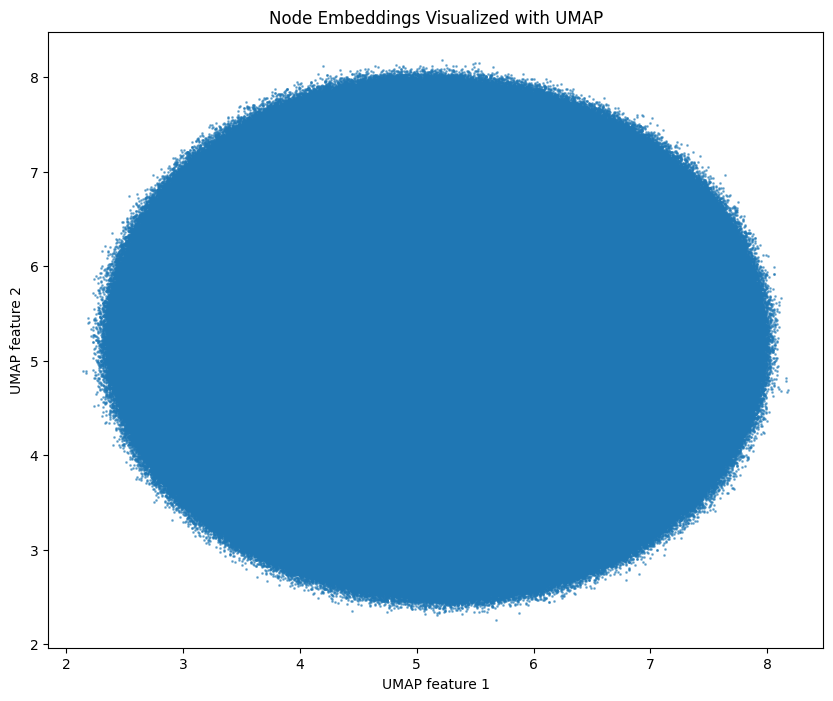

In [7]:
from umap import UMAP
import matplotlib.pyplot as plt
import os
def visualize_embeddings_with_umap(embeddings):
    umap = UMAP(n_components=2, n_jobs=-1)
    embeddings_umap = umap.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], s=1, alpha=0.5)
    plt.title('Node Embeddings Visualized with UMAP')
    plt.xlabel('UMAP feature 1')
    plt.ylabel('UMAP feature 2')
    plt.show()

# Вызов функции визуализации с UMAP
visualize_embeddings_with_umap(embeddings)


In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random

def generate_negative_samples(num_nodes, positive_samples, num_samples):
    negative_samples = []
    edge_set = set((min(u, v), max(u, v)) for u, v in positive_samples)
    while len(negative_samples) < num_samples:
        u, v = random.sample(range(num_nodes), 2)
        if (u, v) not in edge_set and (v, u) not in edge_set:
            negative_samples.append((u, v))
    return negative_samples

# Получение эмбеддингов
def get_embeddings(model, data, device):
    model.eval()
    with torch.no_grad():
        return model(torch.arange(data.num_nodes, device=device)).detach().cpu().numpy()

# Обучение логистической регрессии для оценки качества эмбеддингов
def evaluate_embeddings(embeddings, edges, num_nodes):
    positive_samples = edges
    negative_samples = generate_negative_samples(num_nodes, positive_samples, len(positive_samples))
    
    labels = [1] * len(positive_samples) + [0] * len(negative_samples)
    pairs = positive_samples + negative_samples
    
    pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, labels, test_size=0.3, random_state=42)
    
    X_train = np.array([embeddings[u] - embeddings[v] for u, v in pairs_train])
    X_test = np.array([embeddings[u] - embeddings[v] for u, v in pairs_test])
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, labels_train)
    
    preds = clf.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(labels_test, preds)
    print("AUC-ROC Score:", auc_score)

# Получение эмбеддингов
embeddings = get_embeddings(model, data_train, device)

# Оценка качества модели
evaluate_embeddings(embeddings, edges, max_node_index)


AUC-ROC Score: 0.6019669376559835


In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random

def generate_negative_samples(num_nodes, positive_samples, num_samples):
    negative_samples = []
    edge_set = set((min(u, v), max(u, v)) for u, v in positive_samples)
    while len(negative_samples) < num_samples:
        u, v = random.sample(range(num_nodes), 2)
        if (u, v) not in edge_set and (v, u) not in edge_set:
            negative_samples.append((u, v))
    return negative_samples

# Получение эмбеддингов
def get_embeddings(model, data, device):
    model.eval()
    with torch.no_grad():
        return model(torch.arange(data.num_nodes, device=device)).detach().cpu().numpy()

# Обучение логистической регрессии для оценки качества эмбеддингов
def evaluate_embeddings_with_pca(embeddings, edges, num_nodes):
    # Применение PCA для уменьшения размерности до 50 компонентов (или меньше)
    pca = PCA(n_components=6)
    embeddings_pca = pca.fit_transform(embeddings)

    positive_samples = edges
    negative_samples = generate_negative_samples(num_nodes, positive_samples, len(positive_samples))
    
    labels = [1] * len(positive_samples) + [0] * len(negative_samples)
    pairs = positive_samples + negative_samples
    
    pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, labels, test_size=0.3, random_state=42)
    
    X_train = np.array([embeddings_pca[u] - embeddings_pca[v] for u, v in pairs_train])
    X_test = np.array([embeddings_pca[u] - embeddings_pca[v] for u, v in pairs_test])
    
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train, labels_train)
    
    preds = clf.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(labels_test, preds)
    print("AUC-ROC Score with PCA:", auc_score)

# Получение эмбеддингов и оценка
embeddings = get_embeddings(model, data_train, device)
evaluate_embeddings_with_pca(embeddings, edges, max_node_index)

AUC-ROC Score with PCA: 0.5062764091032642


In [11]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def evaluate_embeddings_with_xgboost(embeddings, edges, num_nodes):
    positive_samples = edges
    negative_samples = generate_negative_samples(num_nodes, positive_samples, len(positive_samples))
    
    labels = [1] * len(positive_samples) + [0] * len(negative_samples)
    pairs = positive_samples + negative_samples
    
    pairs_train, pairs_test, labels_train, labels_test = train_test_split(pairs, labels, test_size=0.3, random_state=42)
    
    X_train = np.array([embeddings[u] - embeddings[v] for u, v in pairs_train])
    X_test = np.array([embeddings[u] - embeddings[v] for u, v in pairs_test])
    
    dtrain = xgb.DMatrix(X_train, label=labels_train)
    dtest = xgb.DMatrix(X_test, label=labels_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100
    }

    model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtrain, 'train')])

    preds = model.predict(dtest)
    auc_score = roc_auc_score(labels_test, preds)
    print("AUC-ROC Score with XGBoost:", auc_score)

# Получение эмбеддингов и оценка
embeddings = get_embeddings(model, data_train, device)
evaluate_embeddings_with_xgboost(embeddings, edges, max_node_index)


[0]	train-auc:0.77457
[1]	train-auc:0.89774
[2]	train-auc:0.91764
[3]	train-auc:0.93875
[4]	train-auc:0.96082
[5]	train-auc:0.96836
[6]	train-auc:0.97064
[7]	train-auc:0.98057
[8]	train-auc:0.98529
[9]	train-auc:0.98562
[10]	train-auc:0.98767
[11]	train-auc:0.98993
[12]	train-auc:0.99174
[13]	train-auc:0.99322
[14]	train-auc:0.99392
[15]	train-auc:0.99482
[16]	train-auc:0.99518
[17]	train-auc:0.99634
[18]	train-auc:0.99676
[19]	train-auc:0.99703
[20]	train-auc:0.99737
[21]	train-auc:0.99753
[22]	train-auc:0.99765
[23]	train-auc:0.99814
[24]	train-auc:0.99824
[25]	train-auc:0.99825
[26]	train-auc:0.99835
[27]	train-auc:0.99835
[28]	train-auc:0.99859
[29]	train-auc:0.99898
[30]	train-auc:0.99906
[31]	train-auc:0.99905
[32]	train-auc:0.99906
[33]	train-auc:0.99908
[34]	train-auc:0.99926
[35]	train-auc:0.99926
[36]	train-auc:0.99948
[37]	train-auc:0.99947
[38]	train-auc:0.99945
[39]	train-auc:0.99951
[40]	train-auc:0.99960
[41]	train-auc:0.99958
[42]	train-auc:0.99957
[43]	train-auc:0.9995

/home/qtr/.local/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [00:08:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	train-auc:0.99973
[55]	train-auc:0.99976
[56]	train-auc:0.99975
[57]	train-auc:0.99974
[58]	train-auc:0.99985
[59]	train-auc:0.99986
[60]	train-auc:0.99985
[61]	train-auc:0.99985
[62]	train-auc:0.99985
[63]	train-auc:0.99989
[64]	train-auc:0.99989
[65]	train-auc:0.99988
[66]	train-auc:0.99988
[67]	train-auc:0.99993
[68]	train-auc:0.99993
[69]	train-auc:0.99993
[70]	train-auc:0.99993
[71]	train-auc:0.99993
[72]	train-auc:0.99996
[73]	train-auc:0.99998
[74]	train-auc:0.99998
[75]	train-auc:0.99998
[76]	train-auc:0.99997
[77]	train-auc:0.99997
[78]	train-auc:0.99997
[79]	train-auc:0.99997
[80]	train-auc:0.99996
[81]	train-auc:0.99999
[82]	train-auc:0.99999
[83]	train-auc:1.00000
[84]	train-auc:1.00000
[85]	train-auc:1.00000
[86]	train-auc:1.00000
[87]	train-auc:1.00000
[88]	train-auc:1.00000
[89]	train-auc:1.00000
[90]	train-auc:1.00000
[91]	train-auc:1.00000
[92]	train-auc:1.00000
[93]	train-auc:1.00000
[94]	train-auc:1.00000
[95]	train-auc:1.00000
[96]	train-auc:1.00000
[97]	train-